In [1]:
#!/usr/bin/env python

In [2]:
import os
import sys
if os.path.exists('/home/chieh/code/wPlotLib'):
	sys.path.insert(0,'/home/chieh/code/wPlotLib')
if os.path.exists('/home/chieh/code/wuML'):
	sys.path.insert(0,'/home/chieh/code/wuML')

In [3]:
import wuml
import numpy as np
import torch
import torch.nn as nn

In [4]:
wuml.set_terminal_print_options(precision=3)

This code shows how you can mix and match different networks<br>
This network simultaneously minimize CE and MSE loss

In [5]:
def status_printing(all_losses, epoch, lr):
	[total_loss, CE_loss, Regress_loss] = all_losses
	txt = '\tepoch: %d, Tloss: %.4f, CEloss: %.4f, MSELoss: %.4f, Learning Rate: %.8f'%((epoch+1), total_loss, CE_loss, Regress_loss, lr)
	wuml.write_to_current_line(txt)

You can also control the behavior of the network on call

In [6]:
def network_behavior_on_call(all_data, all_networks):
	net1 = all_networks[0]
	net2 = all_networks[1]
#
	#	the 1st 2 items of all_data will always be X, and y
	#	the rest will be what you include
	X = all_data[0]
	y = all_data[1]
#
	ŷₐ = net1(X)
	ŷᵦ = net2(ŷₐ)
#
	labels = wuml.softmax(ŷₐ, turn_into_label=True)
	return ŷᵦ

In [7]:
def costFunction(all_data, all_networks):	
	net1 = all_networks[0]
	net2 = all_networks[1]
#
	#	the 1st 3 items of all_data will always be X, y, index
	#	the rest will be what you include
	X = all_data[0]
	y = all_data[1]
	indx = all_data[2]
	y2= all_data[3]
#
	# run data through the networks
	ŷₐ = net1(X)
	ŷᵦ = net2(ŷₐ)
#
	CE_loss = wuml.CrossEntropyLoss(y, ŷₐ)
	Regress_loss = wuml.MSELoss(y2, ŷᵦ)
	total_loss = 0.1*CE_loss + Regress_loss
#
	return [total_loss, CE_loss, Regress_loss]

In [8]:
def optimizer_steps_order(all_optimizers):
	#	The optimizers are in the order of the network structure you originally defined
	opt1 = all_optimizers[0]
	opt2 = all_optimizers[1]
#
	opt2.step()
	opt1.step()

This data has both regression and classification labels (3 classes)<br>
the network will train on both labels by<br>
	using the 1st network to get 3 softmax outputs, <br>
	from the 1st network, it will connect to the 2nd network, <br>
		expand to width of 5 and compress down to 1 for regression

In [9]:
data = wuml.wData(xpath='../../data/wine.csv', ypath='../../data/wine_label.csv', 
					extra_data='../../data/wine_regress_label.csv', 
					preprocess_data='center and scale', 
					 batch_size=16, label_type='discrete')
Y2 = data.extra_data_dictionary['numpy'][0]

In [10]:
netStructureList = []
netStructureList.append([(100,'relu'),(3,'none')])
netStructureList.append([(50,'relu'),(1,'none')])
netInputDimList = [13, 3]

In [11]:
model = wuml.combinedNetwork(data, netStructureList, netInputDimList, costFunction, force_network_to_use_CPU=True,
							optimizer_steps_order=optimizer_steps_order,
							max_epoch=200, on_new_epoch_call_back=status_printing,
							network_behavior_on_call=network_behavior_on_call,
							Y_dataType=torch.LongTensor, extra_dataType=[torch.FloatTensor]) 
model.fit()
ŷᵦ = model(data)

	epoch: 201, Tloss: 0.0739, CEloss: 0.7063, MSELoss: 0.0033, Learning Rate: 0.00100000

R = wuml.summarize_regression_result(Y2, ŷᵦ)

In [12]:
E = wuml.explainer(data, model, explainer_algorithm='shap')
#exp = E(data[0:10,:], y=Y2)


Note: Since there are too many input samples, kmeans was employed to reduce the sample down to 70



  0%|          | 0/1 [00:00<?, ?it/s]

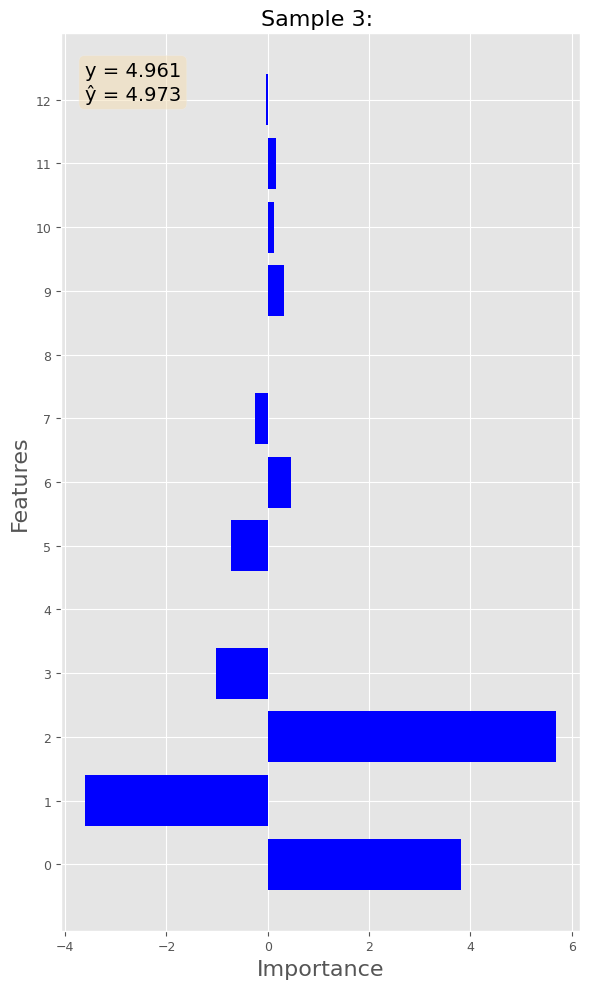

In [13]:
sample_id = 3
E.plot_individual_sample_importance(data[sample_id,:], y=Y2[sample_id], sample_id=sample_id, figsize=(6,10))
wuml.save_torch_network(model, './combined_net.pk')